In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import random
import scipy 
from scipy.optimize import minimize
from numpy import array
from sklearn.metrics import r2_score
from skbio.diversity.alpha import shannon
from scipy import stats
from scipy.spatial.distance import pdist
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
import warnings
warnings.filterwarnings("ignore")

# Read metadata

In [2]:
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_bac = pd.read_csv('../../../our_data/16S_relative_abundance_asv.csv', index_col=0).T
asvs = list(df_bac.columns)
alpha_diversity = -np.sum(df_bac*np.log2(df_bac), axis=1).to_frame()
alpha_diversity.columns = ['AlphaDiversity']
df_meta_bac = pd.merge(df_meta, alpha_diversity, left_index=True, right_index=True, how='inner')
df_meta_bac.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,AlphaDiversity
sample131,BC1,Beijing,0,Control,C,5.438002
sample132,BC2,Beijing,0,Control,B,5.991971
sample133,BC3,Beijing,0,Control,A,5.449612
sample134,BC4,Beijing,0,Control,D,5.992422
sample135,BC5,Beijing,0,Control,E,5.421850


# Fit harmonic model

In [3]:
def harmonic(params,xdata):
    k1,k2,D,H,Ai = params
    ypred = H/k1/k2+((D+k2*Ai-H/k1)*np.exp(-k1*xdata)-(D+k1*Ai-H/k2)*np.exp(-k2*xdata))/(k2-k1)
    return ypred

In [4]:
def residual_harmonic(params,xdata,ydata):
    ypred = harmonic(params,xdata)
    return -r2_score(ydata, ypred)

In [5]:
df_meta_bac_rs = df_meta_bac[df_meta_bac.Diet=='Resistant starch']
all_mice = list(set(df_meta_bac_rs.MiceID))
initial_condition = 'fixedIC' # free initial condition or fixed initial condition

lines = []
for j, mice_ in enumerate(all_mice):
    curr_df = df_meta_bac_rs[df_meta_bac_rs.MiceID==mice_].sort_values(by='Day')
    vendor_ = list(set(curr_df.Vendor))[0]

    # get X and Y data
    xdata = np.array(curr_df.Day)
    ydata = np.array(curr_df.AlphaDiversity)

    # model fitting
    min_obj_over = 1e10
    best_sol_over = None
    trial=0
    while trial < 100:
        try:
            if initial_condition=='freeIC':
                res = minimize(residual_harmonic, 
                               [random(),random(),random(),random(),random()], 
                               args=(xdata,ydata),
                               bounds = ((0, 10), (0, 10), (None, 0), (0, None), (0,None)),
                               method='Powell', # Powell
                               tol=1e-8,
                               options={'maxiter':1000}
                              )
            elif initial_condition=='fixedIC':
                res = minimize(residual_harmonic, 
                   [random(),random(),random(),random(),ydata[0]], 
                   args=(xdata,ydata),
                   bounds = ((0, 10), (0, 10), (None, 0), (0, None), (ydata[0],ydata[0])),
                   method='Powell', # Powell
                   tol=1e-8,
                   options={'maxiter':1000}
                  )
            else:
                print('unknown initial condition: %s'%(initial_condition))
                raise
            assert res.success==True
            if res.fun < min_obj_over:
                best_sol_over = res.x
                min_obj_over = res.fun
            trial += 1
        except:
            pass
    print(mice_)
    print(best_sol_over)
    lines.append([mice_, vendor_] + list(best_sol_over) + [r2_score(ydata, harmonic(best_sol_over, xdata))])

# write to file
df_bfit = pd.DataFrame(lines, columns=['MiceID','Vendor','k1','k2','D','H','Ai','R2'])
df_bfit['zeta'] = [(k1+k2)/2/np.sqrt(k1*k2) for k1,k2 in zip(df_bfit['k1'],df_bfit['k2'])]
df_bfit.to_csv('best_fit_parameters_rs_%s_harmonic.csv'%(initial_condition))

GR5
[ 9.99999996e+00  9.99999997e+00 -9.00697693e-08  6.18702402e+02
  5.16483291e+00]
BR5
[  1.0077229    9.69699016 -25.67150777  52.54823668   6.07260367]
BR4
[ 0.08070975  0.14077669 -0.20664738  0.06870068  5.4946157 ]
GR4
[ 0.08340646  0.08340444 -0.2547214   0.05457031  6.36799844]
GR2
[ 2.68338892e-02  2.19233754e-02 -5.96804847e-09  2.72468291e-15
  6.37737589e+00]
SR3
[ 0.16493349  7.3091261  -6.47513917  5.78379948  4.60803134]
GR3
[ 1.40106757e-08  6.49634352e-02 -6.08315562e-02  4.00838306e-03
  6.19294368e+00]
BR2
[ 0.11648457  2.35039453 -1.4809611   1.4109528   6.17061443]
SR1
[ 1.14901060e-09  9.31506269e-01 -1.19202674e+00  6.84894294e-02
  4.44815671e+00]
SR4
[ 0.0066653   0.01285167 -0.10751737  0.00816898  4.52917357]
SR5
[ 1.35545892e-09  9.93531722e+00 -1.28262530e+01  4.06791592e-01
  5.00522361e+00]
HR5
[ 0.33560615  0.33560606 -0.59837483  0.54768174  6.02841178]
HR4
[ 0.08761861  0.9709913  -0.48283213  0.40262551  5.66850457]
BR3
[ 0.15804487  0.04579335 -0.

In [5]:
df_bfit_harmonic = pd.read_csv('best_fit_parameters_rs_fixedIC_harmonic.csv', index_col=0)
print(df_bfit_harmonic['R2'].mean(), df_bfit_harmonic['R2'].std())

0.611115212547774 0.23786073077835815


# Plot harmonic fitting for rs mice

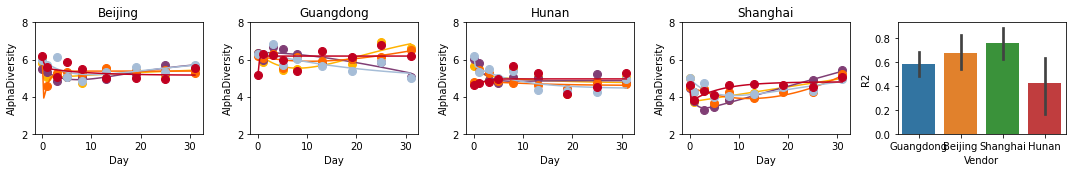

In [8]:
fig, ax = plt.subplots(figsize=(15, 2.5), nrows=1, ncols=5)
df_bfit = pd.read_csv('best_fit_parameters_rs_fixedIC_harmonic.csv')

df_meta_bac_rs = df_meta_bac[df_meta_bac.Diet=='Resistant starch']
colors = ['#FFB300', # Vivid Yellow,
          '#803E75', # Strong Purple
          '#FF6800', # Vivid Orange
          '#A6BDD7', # Very Light Blue
          '#C10020'] # Vivid Red'
for j, vendor_ in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    curr_df = df_meta_bac_rs[df_meta_bac_rs.Vendor==vendor_]
    for k, mice_ in enumerate(set(curr_df.MiceID)):
        curr_df2 = curr_df[curr_df.MiceID==mice_].sort_values(by='Day')

        # get X and Y data
        xdata = np.array(curr_df2.Day)
        ydata = np.array(curr_df2.AlphaDiversity)
        ax[j].plot(xdata, ydata, marker='o', linestyle = 'None', markersize=8, color=colors[k])

        xdata_dense = np.linspace(0,31,100)
        best_sol_over = df_bfit.loc[df_bfit.MiceID==mice_, ['k1','k2','D','H','Ai']].values[0]
        ypred = harmonic(best_sol_over, xdata_dense)

        ax[j].plot(xdata_dense, ypred, color=colors[k])
        ax[j].set_title(vendor_)
        ax[j].set_xlabel('Day')
        ax[j].set_ylabel('AlphaDiversity')
        ax[j].set_ylim([2,8])

# plot R2
_ = sns.barplot(x='Vendor', y='R2', data=df_bfit, ax=ax[4])
                
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("harmonic_fitting_scfa_rs_fixedIC.svg", format="svg")

In [7]:
df_bfit = pd.read_csv('best_fit_parameters_rs_fixedIC_harmonic.csv', index_col=0)
df_bfit = df_bfit[['Vendor','zeta']]
df_bfit.sort_values('Vendor')

,Vendor,zeta
0,Beijing,1.000000
10,Beijing,1.000000
16,Beijing,2.490409
5,Beijing,1.000000
17,Beijing,1.416104
2,Guangdong,1.000000
9,Guangdong,1.002093
1,Guangdong,7378.430141
11,Guangdong,1.000000
3,Hunan,1.000000


# Plot 1/k1 and 1/k2

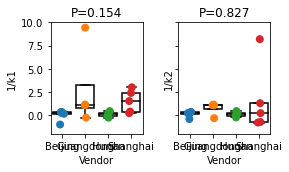

In [20]:
df_bfit = pd.read_csv('best_fit_parameters_rs_fixedIC_harmonic.csv', index_col=0)
df_bfit = df_bfit[['MiceID','Vendor','k1','k2']]
df_bfit['1/k1'] = np.log10(1/df_bfit['k1'])
df_bfit['1/k2'] = np.log10(1/df_bfit['k2'])

# plot statistical comparison
fig, ax = plt.subplots(figsize=(4,2.5), nrows=1, ncols=2, sharex=True, sharey='row')
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

for j,par in enumerate(['1/k1','1/k2']):
    df_tmp = df_bfit
    _ = sns.boxplot(x='Vendor', y=par, hue='Vendor',data=df_tmp.sort_values('Vendor'), color=None, dodge=False, ax=ax[j], showfliers=False, **PROPS)
    _ = sns.stripplot(x='Vendor', y=par, data=df_tmp, size=8, dodge=False, ax=ax[j])
    _ = ax[j].legend().remove()

    # group-wise test
    dm = pdist(np.asarray(df_tmp[par].values).reshape(-1,1), metric='minkowski')
    DM = DistanceMatrix(dm,list(df_tmp.MiceID))
    stats = permanova(DM, grouping=list(df_tmp.Vendor), permutations=999)
    _ = ax[j].set_title('P=%2.3f'%(stats['p-value']))
    _ = ax[j].set_ylim([-2,10])

plt.tight_layout()
# save figure
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("individualized_response_harmonic_model_k1_k2.svg", format="svg")